# Introducción

En el siguiente documento se procede al análisis y preprocesamiento de las imágenes del dataset del White Matter Hyperintensity Segmentation Challenge[1]. El dataset contiene un conjunto de datos de resonancia magnética del cerebro con diversas lesiones de materia blanca. Se obtuvo a través del repositorio oficial del concurso.

# Carga de paquetes

A continuación se muestran los paquetes y librerías empelados para hacer esta tarea.

In [1]:
import torch
import torch.nn as nn

from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import random
from tqdm import tqdm

import os
import numpy as np
import matplotlib.pyplot as plt


import pylab as pl
from IPython import display


import nibabel as nib

c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Datos

El dataset contiene una serie de directorios: [pág. 7 readme.pdf]

- training: Contiene los datos de entrenamiento. Los datos se dividen en tres carpetas, Amsterdam, Utrecht, Singapore ya que los datos provienen de diferentes hospitales de Amsterdam y Singapur. 
- test: Contiene los datos de test. También sigue la estructura del directorio training- 
- additional_annotations: Contiene anotaciones manuales adicionales de los datos. 

En el dataset, para cada una de las resonancias, has dos directorios y la segmentación manual de la resonancia. El primer directorio orig contiene las imágenes originales y el directorio pre contiene las imágenes preprocesadas con el software [SPM12 r6685](http://www.fil.ion.ucl.ac.uk/spm/software/spm12/). Este software se emplea para el análisis de imágenes funcionales de cerebros y su procesamiento. 

En nuestro dataset existen tres tipos de resonancias: 

- FLAIR: Nos permite observar ciertos problemas del cerebro al reducir la señal del líquido cefalorraquídeo. Ayuda a encontrar enfermedades que afectan el cerebro. El líquido aparece brillante lo que indica problemas médicos ( tumores, inflamación o problemas de flujo sanguíneo). También, puede que aparezca brillante por problemas técnicos al tomar la imagen. [2]

- T1: Estas resonancias muestran partes brillantes que representan los tejidos que con protones que no se mueven mucho. Mientras, el líquido cefalorraquídeo aparece más oscuros.[3] Más adelante podremos observar que las manchas en esta resonancia se ven oscuras. 

- 3DT1: No serán empleadas al no ir alienadas con la máscara proporcionada. 

- T2: Estas resonancias muestran diferentes problemas como sangrado, hinchazón, tumores o tejido muerto. Las zonas que aparecen brillantes son aquellas donde los protones se mueven. El líquido cefalorraquídeo se verá brillante. [3]

Además, las imágenes tienen el formato .nii.gz. Este formato indica que se trata de una neuroimagen [NIFTI](https://nifti.nimh.nih.gov/). Por ello, vamos a emplear la librería nibabel para poder leer los archivos y mostrarlos.  Para [instalar la librería](https://pypi.org/project/nibabel/) se debe ejecutar el siguiente comando en el entorno de conda que se emplee: 

In [18]:
#pip install nibabel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 14.9 MB/s eta 0:00:0000:0100:01
ERROR: Could not install packages due to an OSError: [Errno 13] Permiso denegado: '/opt/environment/lib/python3.10/site-packages/nibabel'
Check the permissions.

Note: you may need to restart the kernel to use updated packages.


Emplearemos la función load(), indicando el path a la imagen para poder cargar el fichero.

## Carga de Datos

A continuación, vamos a cargar los datos proporcionadoos en un diccionario. En primer lugar, guardamos las direcciones a los directorios de datos en diferentes constantes. Tenemos una constante con la dirección a la carpeta datos, posteriormente para cada lugar(Amsterdam, Singapore y Utrecht) se crea una constante para su directorio de train y test.

In [2]:
BASE_PATH = os.getcwd() + "\\ICPR"
TRAINING_PATH= BASE_PATH + "\\train\\"

TEST_PATH_AMSTERDAM= BASE_PATH + "/test/"

Creamos la siguiente función "createDictionary", tiene como parámetros un string con el path al directorio y un diccionario donde se almacenan los datos. 

Se cargaran los paths de las resonancias preprocesadas del directorio pre. 

Por cada directorio se listan los subdirectorios que contienen las resonancias FLAIR, T1 y la máscara marcada manualmente y se añaden cada uno al diccionario en la key correspondiente:

In [3]:
def createDictionary(path:str, DICT: dict):
    subdirectories= os.listdir(path)
    for x in subdirectories:
        for y in os.listdir(os.path.join(path, x)):
            t1_file = f"{x}_{y}_T1.nii.gz"
            t2_file = f"{x}_{y}_T2.nii.gz"
            flair_file = f"{x}_{y}_FLAIR.nii.gz"
            mask_file = f"{x}_{y}_MASK.nii.gz"
            DICT["mask"].append(os.path.join(path,x,y,mask_file))
            DICT["pathsT1"].append(os.path.join(path,x, y,t1_file))
            DICT["pathsFLAIR"].append(os.path.join(path,x, y,flair_file))
            DICT["pathsT2"].append(os.path.join(path,x, y,t2_file))

Creamos el diccionario de training inicialmente vacío que almacenará los paths a las resonancias FLAIR, T1 y las máscaras. Comprobamos que se han almacenado correctamente los datos y la cantidad de imágenes que contiene el training: 

In [4]:
TRAINING_DICT={
    "pathsFLAIR":[],
    "pathsT1":[],
    "pathsT2":[],
    "mask" :[]
}
createDictionary(TRAINING_PATH, TRAINING_DICT)
print(TRAINING_DICT.get("pathsFLAIR").__getitem__(0))
print(TRAINING_DICT.get("pathsT1").__getitem__(0))
print(TRAINING_DICT.get("pathsT2").__getitem__(0))
print(TRAINING_DICT.get("mask").__getitem__(0))
print(len(TRAINING_DICT.get("pathsFLAIR")))

c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\ICPR\train\P1\T1\P1_T1_FLAIR.nii.gz
c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\ICPR\train\P1\T1\P1_T1_T1.nii.gz
c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\ICPR\train\P1\T1\P1_T1_T2.nii.gz
c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\ICPR\train\P1\T1\P1_T1_MASK.nii.gz
93


In [5]:
TEST_DICT={
    "pathsFLAIR":[],
    "pathsT1":[],
    "pathsT2":[],
    "mask" :[],
}
createDictionary(TEST_PATH, TEST_DICT)
print(TEST_DICT.get("pathsFLAIR").__getitem__(0))
print(TEST_DICT.get("pathsT1").__getitem__(0))
print(TEST_DICT.get("pathsT2").__getitem__(0))
print(TEST_DICT.get("mask").__getitem__(0))

NameError: name 'TEST_PATH' is not defined

Vamos a observar cuántas imágenes hay de cada tipo en cada uno de los conjuntos: 

In [88]:
print("total training FLAIR images", len(TRAINING_DICT.__getitem__("pathsFLAIR")))
#print("total test FLAIR images", len(TEST_DICT.__getitem__("pathsFLAIR")))

print("total training T1 images", len(TRAINING_DICT.__getitem__("pathsT1")))
print("total training T2 images", len(TRAINING_DICT.__getitem__("pathsT2")))
#print("total test T1 images", len(TEST_DICT.__getitem__("pathsT1")))

total training FLAIR images 93
total training T1 images 93
total training T2 images 93


Como podemos observar tenemos un desbalance de datos. Lo usual es que haya más datos de entrenamiento que de test. En nuestro caso podemos observar que sucede lo contrario. Este desbalance es de casi el doble de datos. También, es un dataset bastante pequeño, ya que consta de 120 imágenes para training y de 220 para test.

Esto nos indica que posiblemente deberemos añadir más imágenes en el entrenamiento. O bien adquiridas a través de otros datasets o bien mediante la aplicación de efectos ( data augmentation)

## Visualización de los datos

A continuación vamos a observar como son las imágenes proporcionadas:

<function matplotlib.pyplot.show(close=None, block=None)>

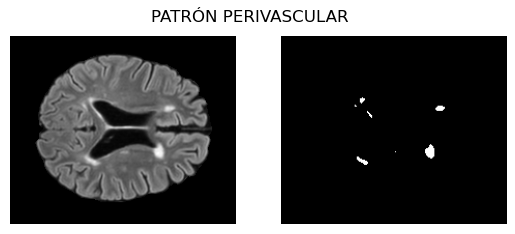

In [37]:
fig, axs =plt.subplots(1, 2) 
img = nib.load(os.path.join(TRAINING_PATH, "P47", "T1", "P47_T1_FLAIR.nii.gz"))
image_data = img.get_fdata() 
axs[0].imshow(image_data[:, :, image_data.shape[2]//2], cmap='gray')
axs[0].axis('off')
img = nib.load(os.path.join(TRAINING_PATH, "P47", "T1", "P47_T1_MASK.nii.gz"))
image_data = img.get_fdata() 
axs[1].imshow(image_data[:, :, image_data.shape[2]//2], cmap='gray')
axs[1].axis('off')
fig.suptitle('PATRÓN PERIVASCULAR')
plt.subplots_adjust(top=1.35)
plt.show

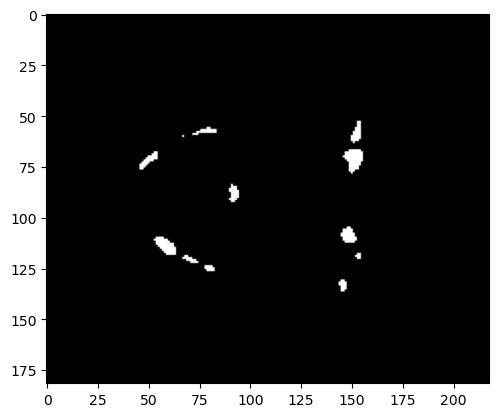

In [19]:
img = nib.load(os.path.join(TRAINING_PATH, "P47", "T1", "P47_T1_MASK.nii.gz"))
image_data = img.get_fdata() 
plt.imshow(image_data[:, :, 85], cmap='gray')

(182, 218, 182)
(182, 218, 182)
(182, 218, 182)
(182, 218, 182)


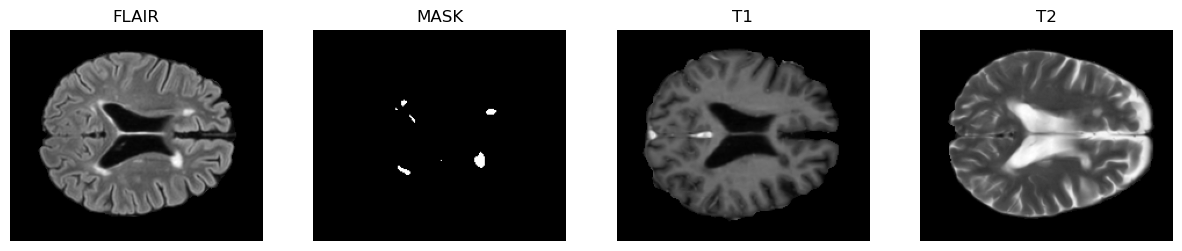

In [93]:
files = os.listdir(os.path.join(TRAINING_PATH, "P47", "T1"))
fig,axs = plt.subplots(1, 4, figsize=(15,5))
x=0
label=["FLAIR","MASK","T1","T2"]
for i in (files):
    img = nib.load(os.path.join(TRAINING_PATH, "P47", "T1", i))
    image_data = img.get_fdata() 
    axs[x].imshow(image_data[:, :, image_data.shape[2]//2], cmap='gray')
    print(image_data.shape)
    axs[x].set_title(label[x])
    axs[x].axis('off')
    x+= 1
plt.show()

(182, 218, 182)
(182, 218, 182)


(-0.5, 217.5, 181.5, -0.5)

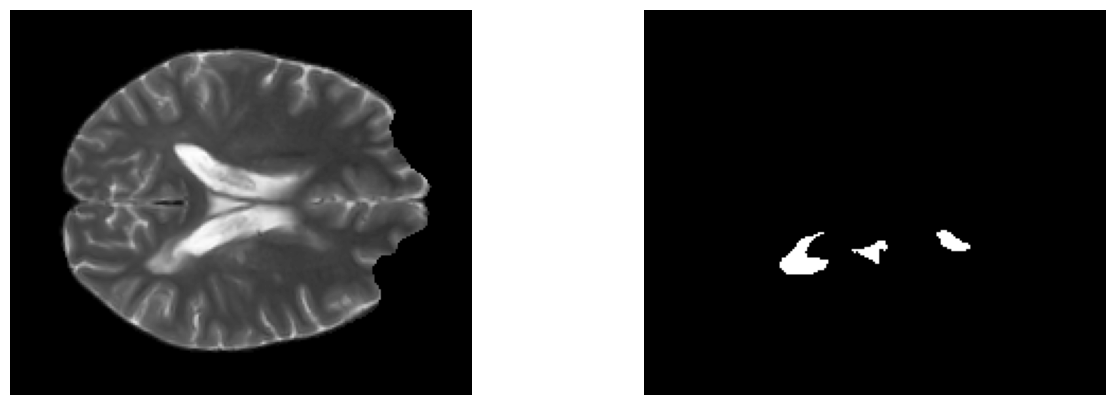

In [83]:
fig,axs = plt.subplots(1, 2, figsize=(15,5))
img = nib.load(os.path.join(TRAINING_PATH, "P1", "T2", "P1_T2_T2.nii.gz"))
image_data = img.get_fdata()
print(image_data.shape) 
axs[0].imshow(image_data[:, :,90], cmap='gray')
axs[0].axis('off')

img = nib.load(os.path.join(TRAINING_PATH, "P1", "T2", "P1_T2_MASK.nii.gz"))
image_data = img.get_fdata() 
print(image_data.shape)
axs[1].imshow(image_data[:, :,90], cmap='gray')
axs[1].axis('off')

## Características de las imágenes

A continuación vamos a observar algunas características de las imágenes.

### Tamaño

In [26]:
def get_shapes_from_dict(data_dict):
    shapes = {
        "mask": [],
        "pathsT1": [],
        "pathsFLAIR": [],
        "pathsT2":[]
    }

    for key in ["mask", "pathsT1", "pathsFLAIR","pathsT2"]:
        for file_path in data_dict[key]:
            img = nib.load(file_path)
            data = img.get_fdata()
            shapes[key].append(data.shape)
    
    return shapes

# Obtener las formas de los archivos NIfTI del diccionario
shapes = get_shapes_from_dict(TRAINING_DICT)



Como podemos observar solo hay cuatro tamaños predeterminados de imagen. Siendo las resonanciass de Amsterdam las más altas y menos anchas, las de Singapur tienen dos tamaños de imagen y las de Utrecht poseen el mismo ancho y alto. 

En el siguiente gráfico se pueden observar para cada lugar, el número exacto de imágenes que hay según el tamaño:

In [28]:
size_location_counts = {}
for size in shapes.get("pathsFLAIR"):
    if (size) not in size_location_counts:
        size_location_counts[(size)] = 0
    size_location_counts[(size)] += 1
    
print(size_location_counts)
size_location_counts = {}
for size in shapes.get("pathsT1"):
    if (size) not in size_location_counts:
        size_location_counts[(size)] = 0
    size_location_counts[(size)] += 1
    
print(size_location_counts)
size_location_counts = {}
for size in shapes.get("pathsT2"):
    if (size) not in size_location_counts:
        size_location_counts[(size)] = 0
    size_location_counts[(size)] += 1
    
print(size_location_counts)

{(182, 218, 182): 93}
{(182, 218, 182): 93}
{(182, 218, 182): 93}


## Conjuntos Train y Test

Como hemos comentado anteriormente, las imágenes poseen tamaños diversos. Por ello inicialmente, seràn redimensonadas a un tamaño de 128x128. El siguiente fragmento de código transforma la imagen a tensor y redimensiona a 128x128. 

Por otra parte, la máscara se redimensiona empleando el método de inteporlación NEAREST. Este método asigna el valor del píxel más cercano a la imagen original.  La palicación de este método nos beneficia ya que permite mantener los límites de la cada clase en la máscara segmentada y evitar la introducción de cambios en la información de las máscaras.[2]

In [8]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128), antialias=True),
    ])

transform_label=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128), antialias=True, interpolation= transforms.InterpolationMode.NEAREST),
])

En la siguiente clase, se muestra como se crea el dataset. Se pasa por parámetro las imágenes, las máscaras segmentadas(labels) y los dos transformadores. 


In [9]:
class Data(Dataset):
    def __init__(self, images, labels, transform, transform_label):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        self.transform_label = transform_label
        
    def __len__(self): 
        return self.len
    
                
    def __getitem__(self, index):
        path = self.paths[index]
        label = self.labels[index]
        
        img = nib.load(path)
        image= img.get_fdata() 

        lab = nib.load(label)
        label_img =  lab.get_fdata()
       
        label_img[label_img==2]=0
       
        
        image = self.transform(image)
        label_img = self.transform_label(label_img)
        image= image[image.shape[0] // 2,:,:].unsqueeze(0)
        label_img= label_img[label_img.shape[0] // 2,:,:].unsqueeze(0)

      
        
        
        return image,label_img    

Creamos los dos datasets de train  y test. En primer lugar realizaremos la segemntación con FLAIR, posteriormente emplearemos T1. 

In [10]:
##FLAIR
train_data = Data(TRAINING_DICT.get("pathsFLAIR"), TRAINING_DICT.get("mask"), transform, transform_label)
print(train_data.len)
val_data = Data(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label)
print(val_data.len)

60
110


Creamos los dataloaders para cada uno de los conjuntos. Estos sirven para cargar los datos en lotes durante el entrenamiento. Si usamos shuffle se mezclan los lotes de forma aleatoria. 

In [11]:
train_dl = DataLoader(train_data, batch_size=5, shuffle=True)
test_dl = DataLoader(val_data, batch_size=15, shuffle=True)

# Referencias 

[1] Kuijf, Hugo; Biesbroek, Matthijs; de Bresser, Jeroen; Heinen, Rutger; Chen, Christopher; van der Flier, Wiesje; Barkhof; Viergever, Max; Biessels, Geert Jan, 2022, "Data of the White Matter Hyperintensity (WMH) Segmentation Challenge", https://doi.org/10.34894/AECRSD, DataverseNL, V1

[2]J. Miranda Bautista, I. Garrido Morro, P. Fernández García, I. Herrera Herrera,"Hiperintensidad en secuencia FLAIR del LCR en el espacio subaracnoideo: diagnósticos diferenciales", Enero,  2022, https://www.elsevier.eses-revista-radiologia-119-avance-resumen-hiperintensidad-secuencia-flair-del-lcr-S0033833822000534?newsletter=true, Servicio de Radiodiagnóstico, HGU Gregorio Marañón, Madrid, España

[3]https://saishnp.com/2021/04/20/el-contraste-en-imagen-de-resonancia-magnetica/

[4]Olaf Ronneberger, Philipp Fischer, and Thomas Brox; May, 2015; "U-Net: Convolutional Networks for Biomedical Image Segmentation",https://arxiv.org/pdf/1505.04597.pdf,

[5]https://arxiv.org/pdf/2304.02643.pdf


# Slices

Las imágenes proporcionadas por el dataset se encuentran en 3D, las de Singapur y Utrect contienen el mismo número de filtros. Por ello, podremos conseguir como máximo 48 imágenes: (Tutorial para crear gif:[enlace](https://www.codedex.io/projects/create-a-gif-with-python))

In [64]:
import imageio.v3 as iio
def makeagif(image,n_slices:int, name:str, bright:float):
    images=[]
    slices = image.shape[2] // n_slices
    if(image.shape[2] % n_slices !=0): slices+=1
    for ii in range(n_slices-1,-1,-1):
        im = image_data[:, :, ii * slices]
        im_adjusted = np.clip(im * bright, 0, 255).astype(np.uint8)
        images.append(im_adjusted)
    iio.imwrite(name, images, duration = 100, loop = 0)

In [68]:
flair= os.path.join(TRAINING_PATH, "P1","T1","P1_T1_FLAIR.nii.gz")
img = nib.load(flair)
image_data = img.get_fdata() 
makeagif(image_data,182,"flair.gif",0.15)

mask= os.path.join(TRAINING_PATH, "P1","T1","P1_T1_MASK.nii.gz")
img = nib.load(mask)
image_data = img.get_fdata() 
merged_image= np.array(image_data)
makeagif(image_data,182,"mask.gif",0.15)

t1= os.path.join(TRAINING_PATH, "P1","T1","P1_T1_T1.nii.gz")
img = nib.load(t1)
image_data = img.get_fdata() 
makeagif(image_data,182,"t1.gif",0.15)

t2= os.path.join(TRAINING_PATH, "P1","T1","P1_T1_T2.nii.gz")
img = nib.load(t2)
image_data = img.get_fdata() 
makeagif(image_data,182,"t2.gif",0.15)